In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-03_11-07_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.11127596439169139

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
GC       0.25
NQ       0.25
YM       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES     1367.90
GC    10500.68
NQ    39234.60
YM    22532.60
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

73635.78

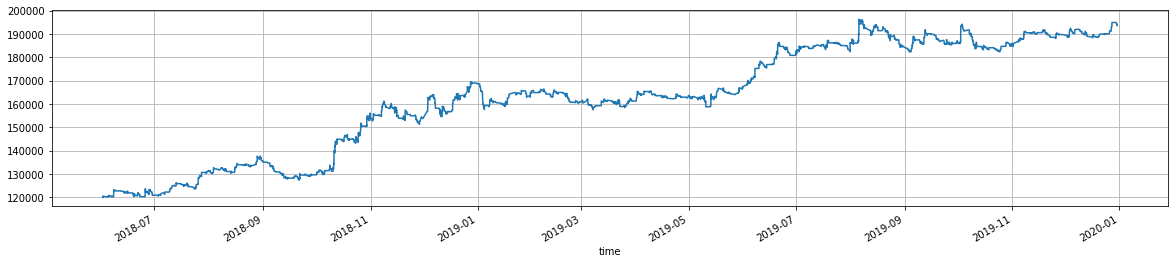

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     677
 GC     947
 NQ    1775
 YM     645
 Name: action, dtype: int64,
 4044)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.643204
 GC    2.298544
 NQ    4.308252
 YM    1.565534
 Name: action, dtype: float64,
 9.815533980582524)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1421.70
GC    2291.74
NQ    3727.50
YM    1354.50
Name: commission, dtype: float64

In [16]:
df.commission.sum()

8795.440000000002

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,22.20,449.63,-264.77,1.70,20.99,473.0
NQ,0.41,44.23,461.96,-245.14,1.88,44.77,887.0
ES,0.39,4.05,799.84,-512.25,1.56,-0.53,338.0
YM,0.41,69.98,714.55,-377.83,1.89,70.05,322.0
total,0.40,36.45,554.79,-316.29,1.75,32.14,2020.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,0.078081,0.197507,0.455659,0.752675
GC,0.078081,1.000000,0.044801,0.071444,0.391818
NQ,0.197507,0.044801,1.000000,0.236961,0.605558
YM,0.455659,0.071444,0.236961,1.000000,0.718334
total,0.752675,0.391818,0.605558,0.718334,1.000000


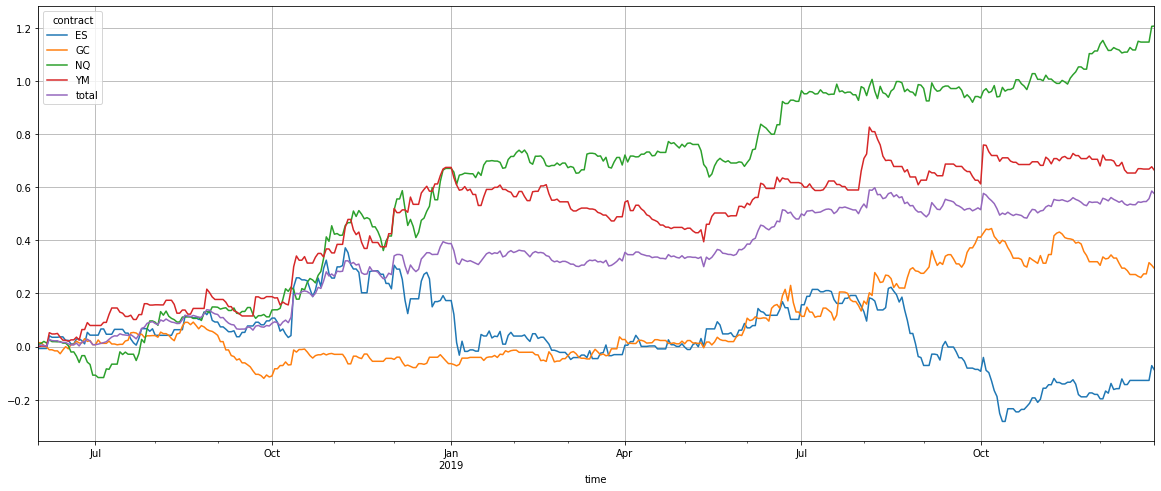

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

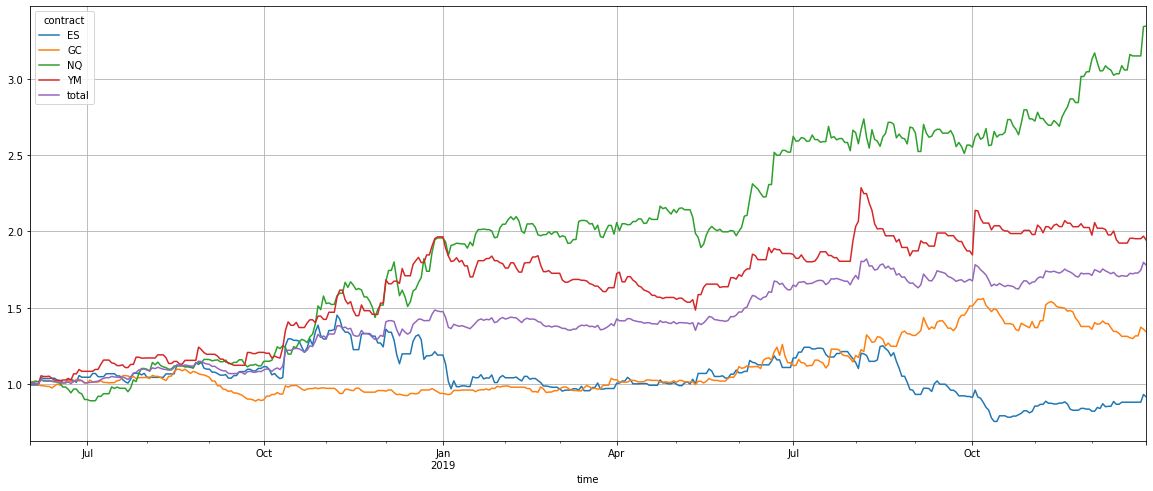

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,-0.052833,0.197084,1.093296,0.500888,0.422126
Cumulative returns,-0.084919,0.341924,2.346051,0.942296,0.778450
Annual volatility,0.409938,0.263768,0.349689,0.331575,0.216082
Sharpe ratio,0.068033,0.811665,2.287546,1.385516,1.736972
Calmar ratio,-0.110024,1.031539,6.746570,2.049141,3.899716
Stability,0.245565,0.643281,0.927279,0.791356,0.901612
Max drawdown,-0.480189,-0.191059,-0.162052,-0.244438,-0.108245
Omega ratio,1.014998,1.177050,1.552143,1.382816,1.400927
Sortino ratio,0.108925,1.468168,4.215032,2.952626,3.322225
Skew,1.374188,1.494481,0.860700,2.462125,1.646225


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,4.39,0.72,-10.22,8.27,0.70
2018-07-31,2.43,3.48,22.67,8.00,9.08
2018-08-31,2.59,0.93,5.41,2.14,2.97
2018-09-30,0.42,-15.23,-3.65,1.07,-4.47
2018-10-31,17.51,9.26,40.96,17.92,21.66
2018-11-30,-3.97,-1.83,-3.79,7.50,-0.22
2018-12-31,-4.33,-1.97,29.02,28.39,12.39
2019-01-31,-11.28,4.99,4.61,-8.94,-2.62
2019-02-28,-7.28,-2.96,-2.46,-3.53,-3.96


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        -8.0
GC        34.0
NQ       235.0
YM        94.0
total     78.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:26:30,YM,BUY,26046.00,4740.80
2018-10-11 04:23:00,ES,BUY,2766.50,4245.80
2019-08-05 21:19:00,YM,BUY,25615.00,3190.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
2019-07-19 00:20:00,GC,SELL,1449.50,3025.16
...,...,...,...,...
2018-12-21 00:01:30,ES,BUY,2488.75,-1391.70
2018-10-30 14:53:30,ES,BUY,2663.00,-1491.70
2018-12-21 16:16:00,ES,BUY,2502.50,-1516.70


In [26]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2018-10-11,0.201107,0.057183,-0.009367,0.092773,0.085424
2018-12-03,0.093193,-0.003989,0.103553,0.099527,0.073071
2019-08-05,0.091387,0.043839,0.035793,0.106360,0.069345
2019-10-02,0.053610,0.015688,0.026633,0.158027,0.063490
2019-06-20,0.030693,0.047860,0.091527,0.014860,0.046235
...,...,...,...,...,...
2018-12-10,-0.049170,0.003172,-0.061173,-0.009087,-0.029064
2018-11-15,-0.074170,-0.003161,-0.013367,-0.038113,-0.032203
2019-05-10,-0.030280,-0.018656,-0.050840,-0.044113,-0.035972
